In [4]:
from sklearnex import patch_sklearn

patch_sklearn()

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from tabulate import tabulate

SAVE_PLOTS = True
PATH = "./machine_learning"
if SAVE_PLOTS and not os.path.exists(PATH):
    os.mkdir(PATH)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
# Read images and masks

images = []
masks = []

IMG_NO = [1, 2, 3, 4, 5]

for i in IMG_NO:
    img = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L.jpg')
    mask = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L_1stHO.png', cv2.IMREAD_GRAYSCALE)
    # img = cv2.imread('./all/images/' + str(i).zfill(2) + '_h.jpg')
    # mask = cv2.imread('./all/manual1/' + str(i).zfill(2) + '_h.tif', cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print('Cannot read mask')
        exit(0)

    if img is None:
        print('Cannot read image')
        exit(0)

    images.append(img)
    masks.append(mask)

In [6]:
# Extract features and labels

def extract_features(crop):
    features = []

    var = np.var(crop)
    features.append(var)

    mean = np.mean(crop)
    features.append(mean)

    moments = cv2.moments(crop)
    hu = cv2.HuMoments(moments).flatten()
    features.extend(hu)
           
    return np.array(features, dtype=np.float32)

def extract_labels(crop):
    if crop[2, 2] > 225:
        return np.float32(1)
    else:
        return np.float32(0)

In [7]:
def create_circular_mask(h, w,):
    
    center = (int(w/2), int(h/2))
    radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def process_within_circle(h, w, circular_mask, data, process_function, output_list):
    for y in range(2, h - 2):
        for x in range(2, w - 2):
            if circular_mask[y, x]: 
                crop = data[y-2:y+3, x-2:x+3]
                output_list.append(process_function(crop))

In [8]:
# Image preprocessing
# Prepare data for training

X = []
y = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for mask in masks:
    h, w = mask.shape
    circular_mask = create_circular_mask(h, w)

    process_within_circle(h, w, circular_mask, mask, extract_labels, y)

for image in images:
    
    image = image[:, :, 1]
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = clahe.apply(image)

    h, w = image.shape
    circular_mask = create_circular_mask(h, w)

    process_within_circle(h, w, circular_mask, image, extract_features, X)

f = len(X[0])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Train set size: ", len(X_train))
print('X_train shape: ', np.array(X_train).shape)
print('y_train shape: ', np.array(y_train).shape)

print('y_train label 1: ', np.count_nonzero(y_train))
print('y_train label 0: ', len(y_train) - np.count_nonzero(y_train))

rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

print("Train set size after undersampling: ", len(X_train))
print('y_train label 1: ', np.count_nonzero(y_train))
print('y_train label 0: ', len(y_train) - np.count_nonzero(y_train))


X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=30000, random_state=42)
print("Train set size after reducing: ", len(X_train))
print('y_train label 1: ', np.count_nonzero(y_train))
print('y_train label 0: ', len(y_train) - np.count_nonzero(y_train))

Train set size:  2532383
X_train shape:  (2532383, 9)
y_train shape:  (2532383,)
y_train label 1:  259300
y_train label 0:  2273083
Train set size after undersampling:  518600
y_train label 1:  259300
y_train label 0:  259300
Train set size after reducing:  30000
y_train label 1:  15043
y_train label 0:  14957


In [10]:
# Build pipeline
# Definiowanie modelu

rfc = RandomForestClassifier()

pipeline = Pipeline([
    ('rfc', rfc)
])

# Definiowanie siatki parametrów do przetestowania
param_grid = {
    'rfc__n_estimators': [10, 100],
    'rfc__max_depth': [None, 20],
    'rfc__min_samples_leaf': [1, 2],
    'rfc__min_samples_split': [2, 5]
}

# Definiowanie obiektu GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)

# Dopasowanie modelu do danych
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [None, 20],
                         'rfc__min_samples_leaf': [1, 2],
                         'rfc__min_samples_split': [2, 5],
                         'rfc__n_estimators': [10, 100]})

In [11]:
# Wyświetlenie najlepszych parametrów i wyniku testu krzyżowego
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'rfc__max_depth': 20, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 100}
Best score:  0.8044666666666667


In [12]:
print('Training accuracy:', grid_search.score(X_train, y_train))
print('Test accuracy:', grid_search.score(X_test, y_test))

Training accuracy: 0.9837
Test accuracy: 0.8085481803766124


In [13]:
# Read images to predict

IMG_NO = [6, 7, 8, 9, 10]

for i in IMG_NO:
    img = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L.jpg')
    mask = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L_1stHO.png', cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print('Cannot read mask')
        exit(0)

    if img is None:
        print('Cannot read image')
        exit(0)

    images.append(img)
    masks.append(mask)

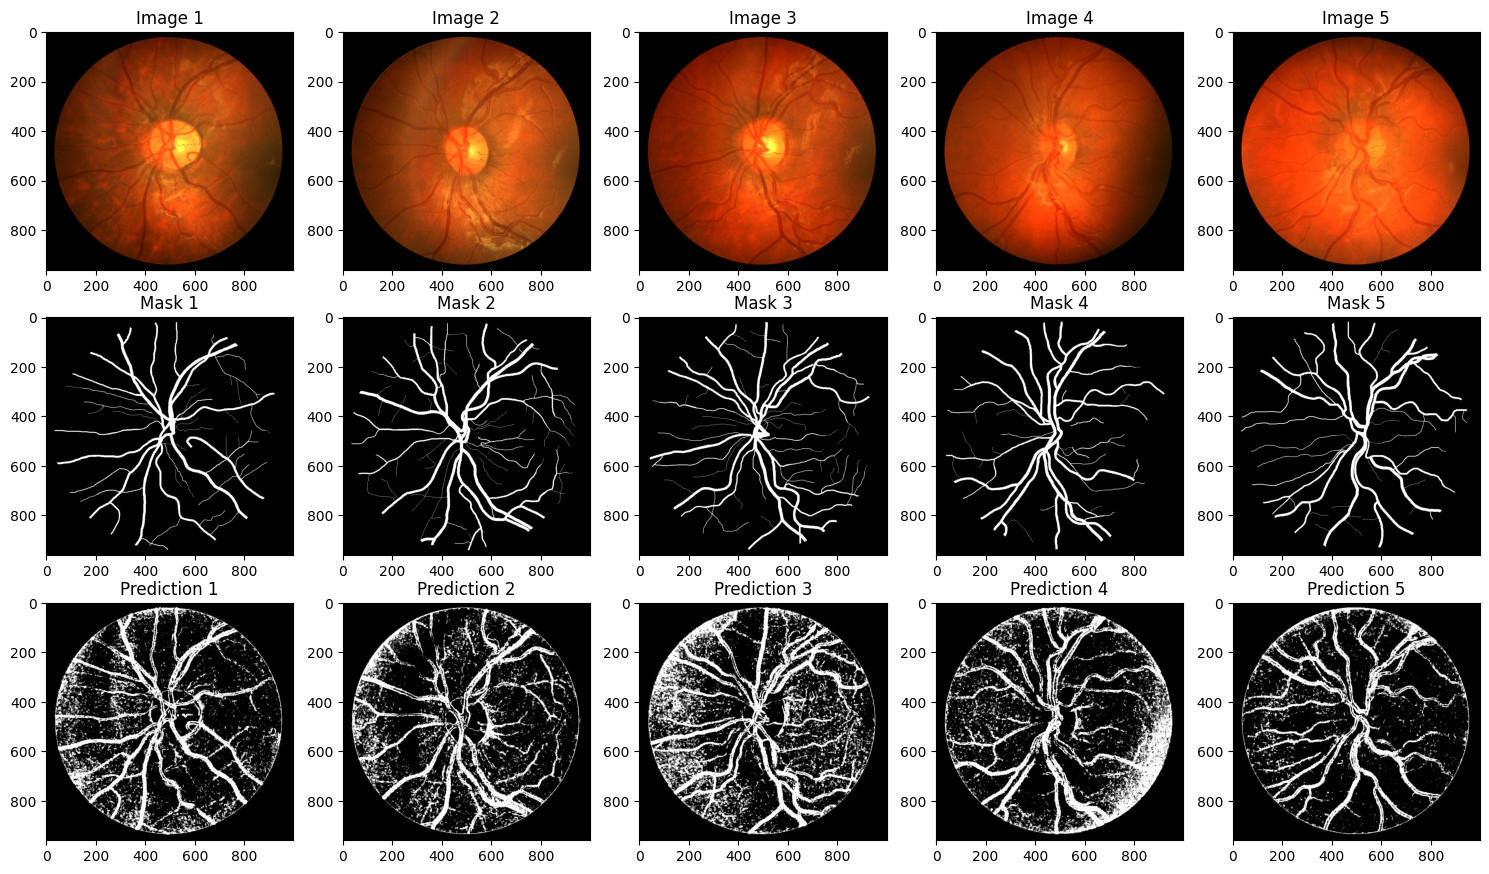

In [21]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

n = len(IMG_NO)
fig, ax = plt.subplots(3, n)
fig.set_size_inches(18.5, 10.5)

PREDICTED = []

for k, new_img, mask in zip(range(n), images, masks):

    ax[0, k].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    ax[0, k].set_title('Image ' + str(k+1))

    ax[1, k].imshow(mask, cmap='gray')
    ax[1, k].set_title('Mask ' + str(k+1))
    
    new_img = new_img[:, :, 1]
    new_img = cv2.GaussianBlur(new_img, (5, 5), 0)
    new_img = clahe.apply(new_img)

    new_img_features = np.zeros((new_img.shape[0], new_img.shape[1], f), dtype=np.float32)

    for i in range(2, new_img.shape[0] - 2, 1):
        for j in range(2, new_img.shape[1] - 2, 1):
            window = new_img[i-2:i+3, j-2:j+3]
            new_img_features[i, j] = extract_features(window)

    y_pred = grid_search.predict(new_img_features.reshape(-1, f)).reshape(new_img.shape[0], new_img.shape[1])
    PREDICTED.append(y_pred)

    ax[2, k].imshow(y_pred, cmap='gray')
    ax[2, k].set_title('Prediction ' + str(k+1))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/prediction.png')

| Method   |   Accuracy |   Sensitivity |   Specificity |
|:---------|-----------:|--------------:|--------------:|
| Image 1  |       0.86 |          0.84 |          0.32 |
| Image 2  |       0.86 |          0.78 |          0.35 |
| Image 3  |       0.82 |          0.87 |          0.28 |
| Image 4  |       0.84 |          0.79 |          0.3  |
| Image 5  |       0.9  |          0.79 |          0.43 |
| Mean     |       0.86 |          0.81 |          0.34 |


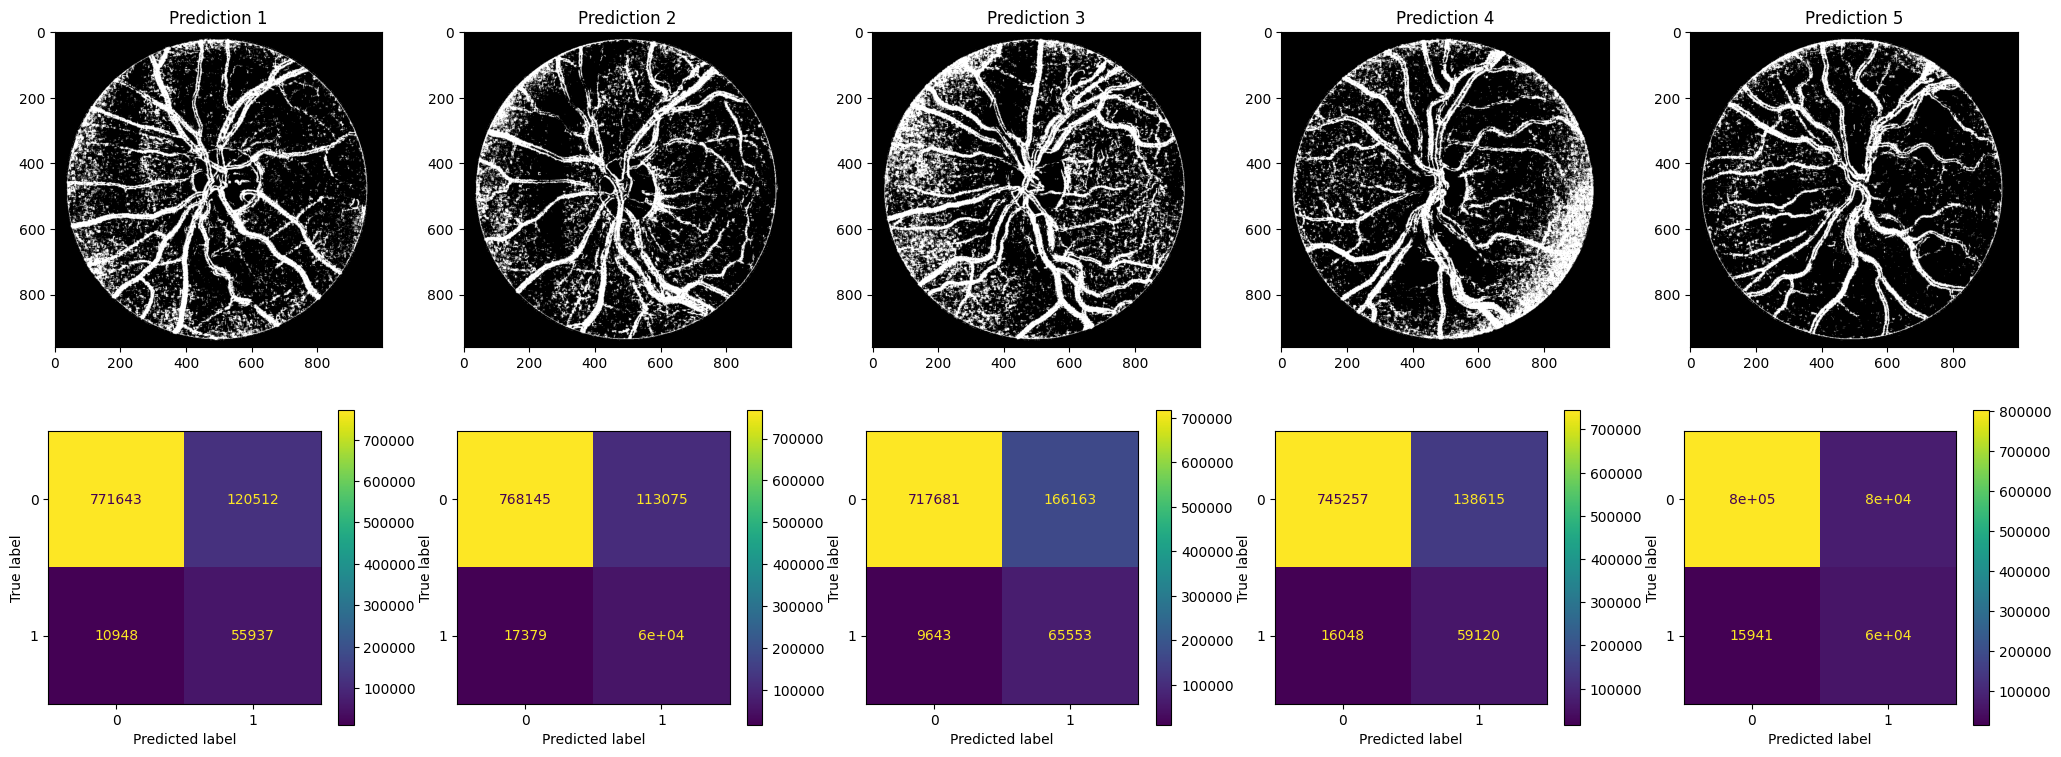

In [17]:
fig, axs = plt.subplots(2, len(IMG_NO)) 
fig.set_size_inches(25.5, 9)

headers = ["Method", "Accuracy", "Sensitivity", "Specificity"]
data = []

for i, expert_mask, predicted in zip(range(len(IMG_NO)), masks, PREDICTED):

    y_true = expert_mask.ravel()
    y_true = y_true / y_true.max()
    
    y_pred = predicted.ravel()
    y_pred = y_pred / y_pred.max()

    cm = confusion_matrix(y_true, y_pred)

    axs[0][i].imshow(predicted, cmap='gray')
    axs[0][i].set_title('Prediction ' + str(i+1))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[1][i])

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    data.append([f"Image {i+1}", f"{accuracy:.2f}", f"{recall:.2f}", f"{precision:.2f}"])

data.append(["Mean", f"{np.mean([float(x[1]) for x in data]):.2f}", f"{np.mean([float(x[2]) for x in data]):.2f}", f"{np.mean([float(x[3]) for x in data]):.2f}"])

print(tabulate(data, headers=headers, tablefmt="pipe"))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/results.png')